In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import util.common as util
from sklearn.ensemble import RandomForestClassifier

# Load Data

In [3]:
clean_dir = "/project/data/cicids2017/clean/"
x_benign_train, y_benign_train, x_benign_val, y_benign_val, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, attack_type_test, attack_type = util.load_data(clean_dir, sample_size=1948, train_size=2, val_size=1363, test_size=56468)

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822     57833       2   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

In [4]:
x_train = np.concatenate((x_benign_val, x_malicious_train))
y_train = np.concatenate((np.full(len(x_benign_val), "Benign"), y_malicious_train))
x_test = np.concatenate((x_benign_test, x_malicious_test))
y_test = np.concatenate((np.full(len(x_benign_test), "Benign"), y_malicious_test))

In [5]:
np.unique(y_train, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Web Attack'], dtype=object),
 array([1364, 1363, 1364, 1364, 1364, 1364]))

In [6]:
y_test[y_test == "Heartbleed"] = "Unknown"
y_test[y_test == "Infiltration"] = "Unknown"

In [7]:
np.unique(y_test, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  584, 56468,   584,   584,   584,    47,   584]))

## Normalise data

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler(quantile_range=(25, 75)),
    'quantile': QuantileTransformer(output_distribution='normal'),
    'minmax': MinMaxScaler(feature_range=(0, 1), copy=True)
}
x_train_s = {}
x_test_s = {}
for key, value in scalers.items():
    x_train_s[key] = value.fit_transform(x_train)
    x_test_s[key] = value.transform(x_test)

# Train Random Forest

In [9]:
scaler = "quantile"
# params = {
#     'max_features': 0.56,
#     'max_samples': 0.56,
#     'min_samples_leaf': 1,
# }
# scaler = 'minmax'
params = {'max_samples': 0.11, 'max_features': 0.060000000000000005, 'min_samples_leaf': 61}
# params = {'max_samples': 0.56, 'max_features': 0.41000000000000003, 'min_samples_leaf': 1}
forest = RandomForestClassifier(random_state=42, oob_score=True)
forest.set_params(**params)
forest.fit(x_train_s[scaler], y_train)

RandomForestClassifier(max_features=0.060000000000000005, max_samples=0.11,
                       min_samples_leaf=61, oob_score=True, random_state=42)

In [10]:
y_proba_train = forest.predict_proba(x_train_s[scaler])
y_proba_test = forest.predict_proba(x_test_s[scaler])

In [11]:
y_p = forest.predict(x_test_s[scaler])

In [12]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
f1_score(y_test, y_p, average='macro')

0.3028171366785811

In [13]:
f1_score(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)], average='macro')

0.3028171366785811

In [14]:
forest.oob_score_

0.8971037516803129

In [15]:
f1_score(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)], average='weighted')

0.7700495621220125

In [16]:
f1_score(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)], average='macro', labels=forest.classes_)

0.35328665945834464

In [17]:
accuracy_score(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)])

0.6762008917304618

In [18]:
balanced_accuracy_score(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)])

0.7676613025862836

In [21]:
balanced_accuracy_score(y_test[y_test != 'Unknown'], forest.classes_[np.argmax(y_proba_test, axis=1)][y_test != 'Unknown'])

0.895604853017331

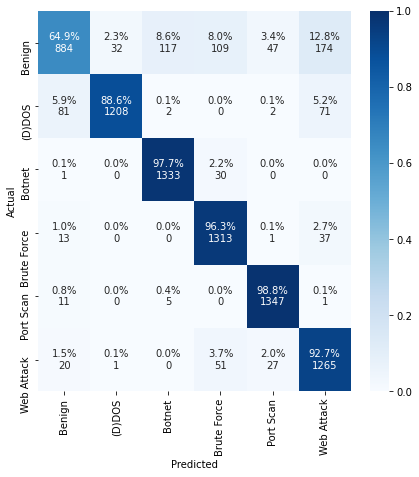

In [16]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack']
fig = util.plot_confusion_matrix(y_train, forest.classes_[np.argmax(y_proba_train, axis=1)], values=classes, labels=classes)

In [77]:
from sklearn.metrics import f1_score
from tqdm import tqdm

thresholds = np.arange(0.0, 1.0, 0.01)
fscore = np.zeros(shape=(len(thresholds)))

# Fit the model
for index, threshold in tqdm(enumerate(thresholds)):
    # Corrected probabilities
    y_pred = np.where(np.max(y_proba_test, axis=1) > threshold, forest.classes_[np.argmax(y_proba_test, axis=1)], 'Unknown')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred, average='weighted')

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

100it [00:53,  1.88it/s]

Best Threshold: 0.39 with F-Score: 0.978


In [78]:
threshold = thresholdOpt
threshold = 0.1
y_pred = np.where(np.max(y_proba_test, axis=1) > threshold, forest.classes_[np.argmax(y_proba_test, axis=1)], 'Unknown')

In [26]:
metrics = { "test": 5, "test_excl": 6}
for k,v in metrics.items():
    print(k, v)

test 5
test_excl 6


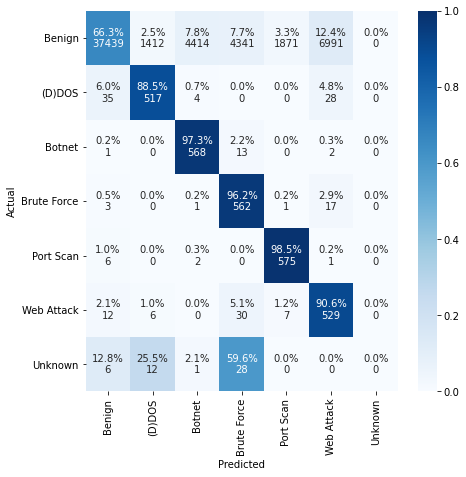

In [20]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(y_test, forest.classes_[np.argmax(y_proba_test, axis=1)], values=classes, labels=classes)

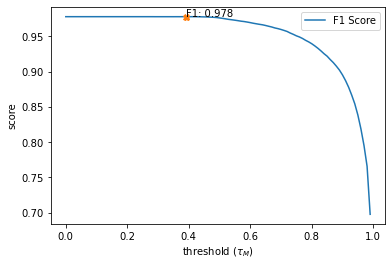

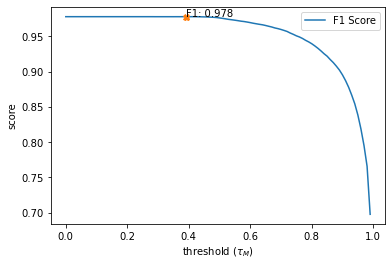

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(thresholds, fscore, label="F1 Score")
plt.plot(thresholdOpt, fscoreOpt, marker="X")
plt.annotate(f"F1: {str(round(fscoreOpt, 3))}", (thresholdOpt, fscoreOpt))
plt.xlabel(r"threshold ($\tau_M$)")
plt.ylabel("score")
plt.legend()
fig

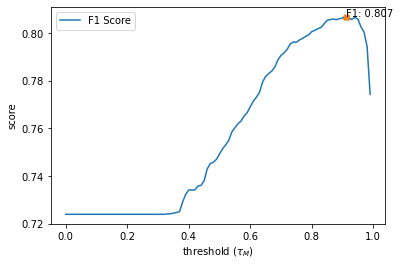

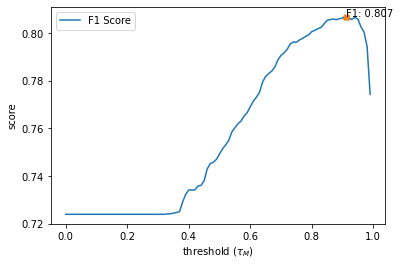

In [68]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(thresholds, fscore, label="F1 Score")
plt.plot(thresholdOpt, fscoreOpt, marker="X")
plt.annotate(f"F1: {str(round(fscoreOpt, 3))}", (thresholdOpt, fscoreOpt))
plt.xlabel(r"threshold ($\tau_M$)")
plt.ylabel("score")
plt.legend()
fig

In [23]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.060000000000000005,
 'max_leaf_nodes': None,
 'max_samples': 0.11,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 61,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
neptune.init(project_qualified_name='verkerken/RandomForestBaseline')